In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
!nvidia-smi

^C


'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd ./drive/MyDrive/NewsGeneration-NLP-Teknofest/Model/

except ImportError:
    print("You are not in a Google Colab environment.")

You are not in a Google Colab environment.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

sys.path.append('../Preprocess-Data/')
from category_reducer import category_reducer

from tensorflow.keras.utils import plot_model

from tensorflow import expand_dims

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D

from tensorflow.keras.applications import MobileNetV2, mobilenet_v2

from tensorflow.keras.layers import Conv2D, Flatten, Reshape
from tensorflow.keras.layers import Embedding, LSTM, Dense, concatenate

from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
def load_data():
    '''
    # Load the data from the csv file and reduce the number of categories
    '''
    data_path = "../Data/news-data-with-imgs.csv"
    data = pd.read_csv(data_path)
    df = data.copy()

    df = category_reducer(df)
    print(df.info())
    df = df[['Content', 'Title', 'img_path']]
    return df

df = load_data()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Title                2 non-null      object
 1   Content              2 non-null      object
 2   Content_url          2 non-null      object
 3   News_type            2 non-null      object
 4   Day_month_year_hour  2 non-null      object
 5   Img_url              2 non-null      object
 6   img_path             2 non-null      object
dtypes: object(7)
memory usage: 240.0+ bytes
None


In [42]:
img_preprocessor = PreprocessImg()

loaded_imgs = img_preprocessor.load_img(df, target_size=(224, 224))
image_data = img_preprocessor.img_to_array()

img_preprocessor.get_size_info(loaded_imgs)
print('Image shapes: ', image_data.shape)

Max width:  224
Min width:  224
Mean width: 224.0
Standard deviation of widths: 0.0
==
Max height: 224
Min height: 224
Mean height: 224.0
Standard deviation of heights: 0.0
Image shapes:  (2, 224, 224, 3)


In [55]:
tokenizer = PreprocessText()

tokenizer.preprocess(df['Title'])

padded_tokens = tokenizer.padded_tokens
max_tokens = tokenizer.max_tokens
vocab_size = tokenizer.vocab_size

start_token = tokenizer.word_index[tokenizer.start_mark.strip()]
end_token = tokenizer.word_index[tokenizer.end_mark.strip()]

tokenizer.save_tokenizer('tokenizer.pkl')

In [56]:
X_images, X_texts, y_texts = tokenizer.generate_data(image_data)

tokenizer.get_info()

Max tokens:  11
Min tokens:  8
Mean tokens:  9
Standard deviation of tokens:  1
==
Vocabulary Size:  18
Shape of padded tokens:  (2, 11)
X_images shape:  (20, 224, 224, 3)
X_texts shape:  (20, 11)
y_texts shape:  (20, 18)


In [31]:
class Img2TextModel():
    """
    # Image captioning model that generate meaningfull context and title from and image.
    """
    @staticmethod
    def CNN_encoder():
        """
        # Encoder with MobileNetV2.
        """
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        base_model.trainable = False

        input_layer = Input(shape=(224, 224, 3), name='encoder_input')
        x = base_model(input_layer)
        x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu')(x)
        x = GlobalAveragePooling2D(name='global_average_pooling2d')(x)
        x = Dense(256, activation='relu', name='encoder_dense_1')(x)
        output_layer = Dense(128, activation='relu', name='encoder_output')(x)

        return input_layer, output_layer

    @staticmethod
    def LSTM_decoder():
        """
        # Decoder with LSTM.
        """
        input_layer = Input(shape=(None, ), name='decoder_input')
        embedding_layer = Embedding(input_dim=vocab_size, output_dim=300, input_length=max_tokens, name='decoder_embedding')(input_layer)
        lstm_layer = LSTM(256, return_sequences=True, name='LSTM_layer_1')(embedding_layer)
        lstm_layer = LSTM(128, name='LSTM_layer_2')(lstm_layer)

        return input_layer, lstm_layer

    def build_model(self):
        """
        # Concat layers and build model.
        """
        encoder_input, encoder_output = self.CNN_encoder()
        decoder_input, decoder_output = self.LSTM_decoder()

        combined = concatenate([encoder_output, decoder_output])
        output = Dense(vocab_size, activation='softmax', name='model_output')(combined)

        self.model = Model(inputs=[encoder_input, decoder_input], outputs=output)
        self.model.compile(loss='categorical_crossentropy', optimizer='adam')

        return self.model
    
    def load_model(model_path):
        """
        # Load the model from the given path.
        """
        return load_model(model_path)

In [32]:
model = Img2TextModel()

model = model.build_model()

In [33]:
es = EarlyStopping(monitor='loss', patience=5, verbose=1)

model.fit([X_images, X_texts],
          y_texts,
          epochs=50,
          batch_size=64,
          callbacks=[es])

Epoch 1/50

1/1 [==============================] - 11s 11s/step - loss: 3.0541
Epoch 2/50
1/1 [==============================] - 1s 686ms/step - loss: 3.3152
Epoch 3/50
1/1 [==============================] - 1s 586ms/step - loss: 3.7370
Epoch 4/50
1/1 [==============================] - 1s 599ms/step - loss: 2.9579
Epoch 5/50
1/1 [==============================] - 1s 617ms/step - loss: 3.2328
Epoch 6/50
1/1 [==============================] - 1s 640ms/step - loss: 2.8079
Epoch 7/50
1/1 [==============================] - 1s 607ms/step - loss: 2.8360
Epoch 8/50
1/1 [==============================] - 1s 684ms/step - loss: 2.5890
Epoch 9/50
1/1 [==============================] - 1s 677ms/step - loss: 2.2648
Epoch 10/50
1/1 [==============================] - 1s 641ms/step - loss: 2.2163
Epoch 11/50
1/1 [==============================] - 1s 602ms/step - loss: 2.1680
Epoch 12/50
1/1 [==============================] - 1s 598ms/step - loss: 2.1191
Epoch 13/50
1/1 [==============================] 

In [38]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)           2257984   ['encoder_input[0][0]']       
 tional)                                                                                          
                                                                                                  
 conv2d (Conv2D)             (None, 5, 5, 256)            2949376   ['mobilenetv2_1.00_224[0][0]']
                                                                                                  
 decoder_input (InputLayer)  [(None, None)]               0         []                        

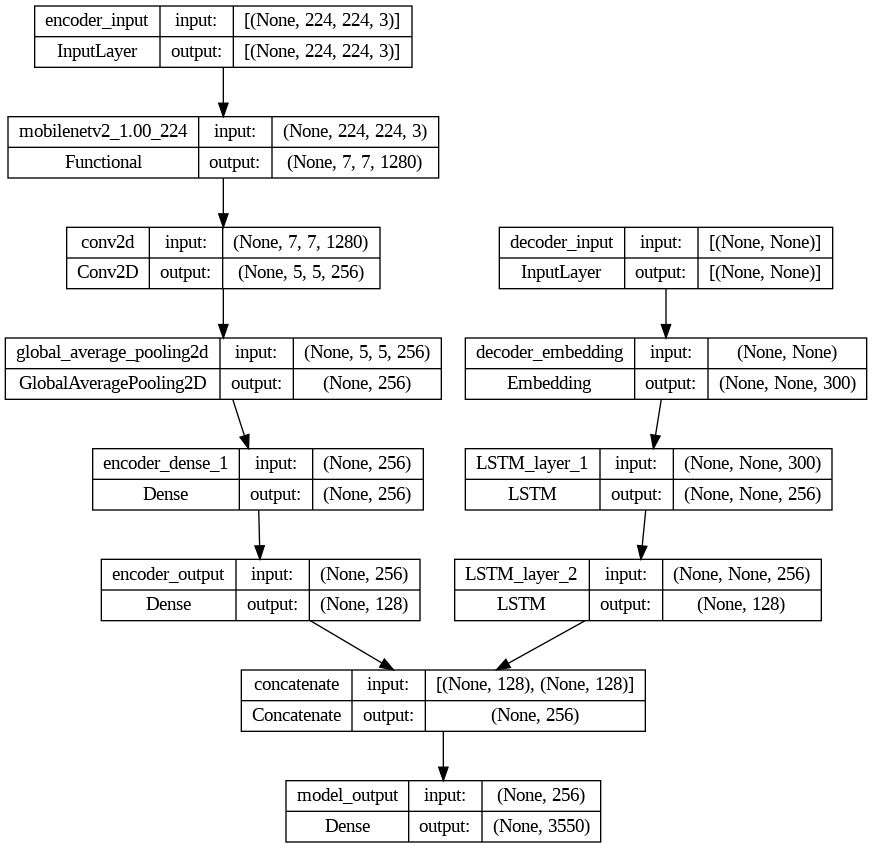

In [15]:
plot_model(model, show_shapes=True)

In [35]:
model.save('img2text_model.h5')